In [1]:
# Import necessary packages
import numpy as np
import gurobipy as grb
import matplotlib.pyplot as plt
import pyqubo
import dimod
from dwave.system import DWaveSampler
import dwave.inspector
from dwave.system.composites import FixedEmbeddingComposite
from minorminer import find_embedding

In [2]:
global maxOptTimsSeconds
maxOptTimsSeconds = -1


def callbackTerminate(model, where):
    global maxOptTimsSeconds
    if where != grb.GRB.Callback.POLLING:
        t = model.cbGet(grb.GRB.Callback.RUNTIME)
        if t >= maxOptTimsSeconds and maxOptTimsSeconds > 0:
            model.terminate()

In [3]:
""" Creation of relaxed MILP model with constraints (subproblem 1) """
def _create_milp_model(T, m, n, A, F, b, gamma, c, eta, V, R):
    """ Prepare the index for decision variables """
    tauVars = [
        (i) for i in range(m)
    ]
    sVars = [
        (t) for t in range(T)
    ]
    yVars = [
        (i,j,t)
        for i in range(m)
        for j in range(n)
        for t in range(T)
    ]
    xVars = [
        (i,t)
        for i in range(m)
        for t in range(T)
    ]

    """ Create model """
    model = grb.Model("IrrigationOptGurobi")

    """ Create decision variables """
    S = model.addVars(sVars, vtype=grb.GRB.CONTINUOUS, lb=0, name="S")
    tau = model.addVars(tauVars, vtype=grb.GRB.BINARY, name="tau")
    Y = model.addVars(yVars, vtype=grb.GRB.BINARY, name="Y")
    X = model.addVars(xVars, vtype=grb.GRB.CONTINUOUS, lb=0, name="X")
    BSWp = model.addVars(xVars, vtype=grb.GRB.CONTINUOUS, lb=0, name="BSWp")
    BSWm = model.addVars(xVars, vtype=grb.GRB.CONTINUOUS, lb=0, name="BSWm")

    # Create net revenue (now set as constants R array)
    # R = np.zeros((m,T),dtype=object)
    # for t in range(T):
    #     for i in range(m):
    #       R[i,t] += (sum(b[i,j,t] * F[i,j,t] * A[i,j,t] for j in range(n)) -
    #                  gamma * X[i,t] * sum(A[i,j,t] for j in range(n)) -
    #                  c[i] * BSWm[i,t] * sum(A[i,j,t] for j in range(n)) -
    #                  c[i] * BSWp[i,t] * sum(A[i,j,t] for j in range(n)))


    """ Create the objective function """
    objFunc = 0.0
    for t in range(T):
        for i in range(0, m - 1):
            for i_prime in range(1, m):
                objFunc += (X[i,t] * sum(A[i,j,t] for j in range(n)) / R[i, t] - X[i_prime,t] * sum(A[i_prime,j,t] for j in range(n)) / R[i_prime, t])
    model.setObjective(objFunc, sense=grb.GRB.MAXIMIZE)

    """ Create constraints """
    # 1. reservoir water balance
    model.addConstrs((grb.quicksum(Y[i,j,t] for i in range(m) for j in range(n)) == 1 for t in range(T)), name="constraint for Y")
    for t in range(1,T):
        model.addConstr(lhs=S[t],
                        sense=grb.GRB.EQUAL,
                        rhs=S[t-1]+sum(eta[i,t] for i in range(m))*sum(A[i,j,t] for i in range(m) for j in range(n))-sum(X[i,t]*sum(A[i,j,t] for j in range(n)) for i in range(m)),
                        name="reservoir water balance")
    # 2. water allocation availability
    for t in range(T):
        model.addConstr(lhs=sum(X[i,t]*sum(A[i,j,t] for j in range(n)) for i in range(m)),
                        sense=grb.GRB.LESS_EQUAL,
                        rhs=S[t] + sum(eta[i,t] for i in range(m))*sum(A[i,j,t] for i in range(m) for j in range(n)),
                        name="water allocation availability")
    # 3. reservoir storage capability
    for t in range(T):
        model.addConstr(lhs=S[t], sense=grb.GRB.LESS_EQUAL, rhs=V[t], name="reservoir storage capability")
    # # 4. water distribution availability --> quantum part
    # model.add_constraints((sum(Y[i,j,t]*A[i,j,t] for j in range(n)) <= X[i,t]*sum(A[i,j,t] for j in range(n)) + tau[i]*BSWp[i,t]*sum(A[i,j,t] for j in range(n)) + (tau[i]-1)*BSWm[i,t]*sum(A[i,j,t] for j in range(n)) for i in range(m) for t in range(T)), names="water distribution availability")
    # 4. transaction constraint
    model.addConstrs((BSWm[i,t]*sum(A[i,j,t] for j in range(n)) <= X[i,t]*sum(A[i,j,t] for j in range(n)) - sum(Y[i,j,t]*A[i,j,t] for j in range(n)) for i in range(m) for t in range(T)),
                     name="transaction constraint")
    # 5. transaction conservation
    model.addConstrs((BSWp[i,t]*BSWm[i,t]==0 for i in range(m) for t in range(T)),
                          name="transaction conservation")

    return model, X, Y, BSWm, BSWp, S, tau

In [4]:
""" Feasibility by DWave quantum model """
def _feasi_by_quantum(m, n, ET, Y_star, X_star, BSWm_star, BSWp_star, eta):
    model = _create_model(m, n, ET, Y_star, X_star, BSWm_star, BSWp_star, eta)

    # """ Write a log file, cannot call in main() function """
    # output_file = os.getcwd() + "/logs/hybrid/2nd/hybrid-milp-dwave-" + file_name + ".log"
    # model.setParam(grb.GRB.Param.LogFile, output_file)

    return model

In [5]:
""" Creation of quantum annealing model with constraints """
def _create_model(m, n, ET, Y_star, X_star, BSWm_star, BSWp_star, eta):
    tau = {i: pyqubo.Binary("tau_(%d)" % i) for i in range(m)}

    """ Partial solution from classical solver"""
    print("partial solution: {},{},{},{}".format(X_star, Y_star, BSWm_star, BSWp_star))
    t = 1
    H = 0
    
    """ Hamilton function"""
    for i in range(m):
        H += -((1-tau[i])*(X_star[i,t] + eta[i,t] - sum(ET[i,j,t]*A[i,i,t] for j in range(n))) + \
             (sum(Y_star[i,j,t]*A[i,j,t]for j in range(n))) - (sum(Y_star[i,j,t]*A[i,j,t]for j in range(n))) * \
             (X_star[i,t]*sum(A[i,j,t] for j in range(n))+tau[i]*BSWp_star[i,t]*sum(A[i,j,t] for j in range(n))+(tau[i]-1)*BSWm_star[i,t]*sum(A[i,j,t] for j in range(n))))

    #H += pyqubo.Constraint((sum(tau[i] for i in range(m)) - 1)**2, label="constraint1")
    #H += pyqubo.Constraint((sum(tau[i]*tau[i+1] for i in range(m-1)) - 1), label="constraint2")

    """ Create model """
    model = H.compile()

    return model

In [ ]:
# put your TOKEN here
token = "YOUR_TOKEN"

In [6]:
""" optimal irrigation problem by hybrid method of Gurobi MILP and D-Wave QPU """
""" Solve the model and formulate the result """
def solve(T, m, n, A, F, b, gamma, c, eta, V, ET):
    solved = False
    k = 0
    milp_model, X, Y, BSWm, BSWp, S, tau= _create_milp_model(T, m, n, A, F, b, gamma, c, eta, V, R)
    objVal = None

    """ Hybrid strategy """
    try:
        while not solved:
            print("-----------------------------------------ITERATION:--------------------------------", k+1)
            # milp_model.update()
            # milp_model.tune()
            # milp_model.optimize(callbackTerminate)
            # load quadratic program from gurobi model
            milp_model.optimize(callbackTerminate)
            if k > 0:
                print("After getting integer cuts %i:" %(k + 1))

            if milp_model.status == grb.GRB.Status.OPTIMAL:
                print("Value of obj func: {}".format(milp_model.objVal))
                X_star = milp_model.getAttr("X", X)
                print("Initial water: {}".format(X_star))
                Y_star = milp_model.getAttr("X", Y)
                print("Water used: {}".format(Y_star))
                BSWm_star = milp_model.getAttr("X", BSWm)
                print("Amount water bought: {}".format(BSWm_star))
                BSWp_star = milp_model.getAttr("X", BSWp)
                print("Amount water sold: {}".format(BSWp_star))
                """ Check the feasibility subproblem by DWave model """
                model = _feasi_by_quantum(m, n, ET, Y_star, X_star, BSWm_star, BSWp_star, eta)
                qubo, offset = model.to_qubo()
                bqm = dimod.BinaryQuadraticModel.from_qubo(qubo, offset)
                solver = DWaveSampler(token=token,
                                      solver="DW_2000Q_6")
                print("Solver used: {}".format(solver))
                __, target_edgelist, target_adjacency = solver.structure

                emb = find_embedding(qubo, target_edgelist, verbose=1)

                sampler = FixedEmbeddingComposite(solver, emb)
                # sampler = EmbeddingComposite(solver)
                response = sampler.sample(bqm, num_reads=100, chain_strength=4.0)
                sample = response.first.sample
                # next_sequence = pyqubo.solve_qubo(qubo)
                print("Sample result: {}".format(sample))
                for datum in response.data(['sample', 'energy', 'num_occurrences']):
                    print(datum.sample, "Energy: ", datum.energy, "Occurrences: ", datum.num_occurrences)
                # # Inspector
                # dwave.inspector.show(response)
                solved = True
                df = response.to_pandas_dataframe(sample_column=True)
                print(df)
                plt.show(df.hist(column="energy"))
                objVal = milp_model.objVal
            else:
                assign = milp_model.getAttr("X", X)
                """ Infeasible """
                k += 1
                """ Adding integer cuts """
                # 1. Creation of set of elements x[i,m] == 1
                set_xim = [i for i in range(m) for t in range(T) if
                           assign[(i,t)].x == 1]
                # 2. Add constraint to MILP model
                milp_model.addConstrs((grb.quicksum([assign[(i,t)] for i in set_xim
                                                      for t in range(T)
                                                      if assign[(i,t)].x == 1]) <= len(set_xim) - 1
                                        for m in range(T)), name="integer cut")
    except grb.GurobiError as e:
        print("Error code " + str(e.errno) + ": " + str(e))

    return objVal, solved

Using license file /home/hoale/gurobi.lic
Academic license - for non-commercial use only
-----------------------------------------ITERATION:-------------------------------- 1
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (linux64)
Optimize a model with 13 rows, 47 columns and 75 nonzeros
Model fingerprint: 0xb3121b62
Model has 6 quadratic constraints
Variable types: 20 continuous, 27 integer (27 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [9e-04, 6e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+03]
Presolve removed 7 rows and 39 columns
Presolve time: 0.00s
Presolved: 6 rows, 8 columns, 18 nonzeros
Variable types: 5 continuous, 3 integer (3 binary)

Root relaxation: objective 4.601102e+00, 2 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0            

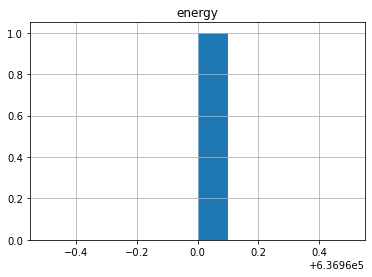

Water allocation difference: 4.601101949160155


In [7]:
StatusDict = {getattr(grb.GRB.Status, s): s for s in dir(grb.GRB.Status) if s.isupper()}

""" Read data """
m = 3 # 3 sub-areas
n = 4 # number of crops
T = 2 # 2 stages of planning and management
# Create A_(i)^(t) matrix (t = 0, first period, i = type of sub-area)
A = np.array([[[277, 120], [280, 200], [148, 232], [228, 250]],
              [[161, 100], [162, 120], [86, 80], [133, 120]],
              [[111, 80], [112, 145], [59, 56], [91, 100]]])
# col 0 = paddy, col 1 = wheat, col 2 = bean, col 3 = oilseed rape
c = [-1635, -21868, -10287, -13635]

F = np.array([[[277, 120], [280, 200], [148, 232], [228, 250]],
              [[161, 100], [162, 120], [86, 80], [133, 120]],
              [[111, 80], [112, 145], [59, 56], [91, 100]]])
b = np.array([[[277, 120], [280, 200], [148, 232], [228, 250]],
              [[161, 100], [162, 120], [86, 80], [133, 120]],
              [[111, 80], [112, 145], [59, 56], [91, 100]]])

gamma = 1.0

eta = np.ones((m,T),dtype=float)

R = np.array([[3000, 44532],
              [23145, 21324],
              [875565, 212324]])

V = [1000, 1000]

ET = np.array([[[277, 120], [280, 200], [148, 232], [228, 250]],
              [[161, 100], [162, 120], [86, 80], [133, 120]],
              [[111, 80], [112, 145], [59, 56], [91, 100]]])

objVal, solved = solve(T, m, n, A, F, b, gamma, c, eta, V, ET)

if solved:
    print("Water allocation difference: {}".format(objVal))